

---



**Question 3 : Part 2**



---



In [4]:
import torch
import torchvision
import numpy as np

# Define the sigmoid and softmax activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Define the cross-entropy loss function
def cross_entropy_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # Convert PIL image to tensor
    torchvision.transforms.Normalize((0.1307,), (0.3081,)) # Normalize the image
])

# Load the MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Set the dimensions of the layers
d = 784
d1 = 300
d2 = 200
d3 = 100
k = 10

# Initialize the weights randomly
W1 = np.random.uniform(-1, 1, size=(d1, d))
W2 = np.random.uniform(-1, 1, size=(d2, d1))
W3 = np.random.uniform(-1, 1, size=(k, d2))

# Set the learning rate and number of epochs
lr = 1
n_epochs = 10

train_loss_history = []

# Train the network
for epoch in range(n_epochs):
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.reshape(-1, d)
        y = torch.nn.functional.one_hot(y, num_classes=k).numpy()
        
        # Forward pass
        z1 = np.dot(X, W1.T)
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2.T)
        a2 = sigmoid(z2)
        z3 = np.dot(a2, W3.T)
        y_hat = softmax(z3.T)
        
        # Compute the loss
        loss = cross_entropy_loss(y.T, y_hat)
        train_loss += loss
        
        # Backward pass
        delta3 = y_hat - y.T
        delta2 = np.dot(delta3.T, W3) * a2 * (1 - a2)
        delta1 = np.dot(delta2, W2) * a1 * (1 - a1)
        dW3 = np.dot(delta3, a2) / X.shape[0]
        dW2 = np.dot(delta2.T, a1) / X.shape[0]
        dW1 = np.dot(delta1.T, X) / X.shape[0]
        
        # Update the weights
        W1 -= lr * dW1
        W2 -= lr * dW2
        W3 -= lr * dW3
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    print(f'Epoch {epoch+1}, train_loss: {train_loss}')


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, train_loss: 34.016162869314975
Epoch 2, train_loss: 11.289382372108514
Epoch 3, train_loss: 7.402192874786428
Epoch 4, train_loss: 4.998432929169592
Epoch 5, train_loss: 3.352377884244576
Epoch 6, train_loss: 2.156367806964447
Epoch 7, train_loss: 1.3781649536407592
Epoch 8, train_loss: 0.8331638888285506
Epoch 9, train_loss: 0.5615255754426789
Epoch 10, train_loss: 0.4110400074670792


In [6]:
test_loss = 0

test_errors = []

prev_loss = 0

for i, (X, y) in enumerate(test_loader):
  X = X.reshape(-1, d)
  y = torch.nn.functional.one_hot(y, num_classes=k).numpy()
        
  # Forward pass
  z1 = np.dot(X, W1.T)
  a1 = sigmoid(z1)
  z2 = np.dot(a1, W2.T)
  a2 = sigmoid(z2)
  z3 = np.dot(a2, W3.T)
  y_hat = softmax(z3.T)
        
  # Compute the loss
  loss = cross_entropy_loss(y.T, y_hat)
  test_loss += loss
  if i%64==0:
    loss_new_batch = loss-prev_loss
    print(loss_new_batch)
    prev_loss = loss_new_batch
        
test_loss /= len(test_loader)
test_loss

3.588098763859121
6.814899574045539
0.08922300326783095


9.92324217986409

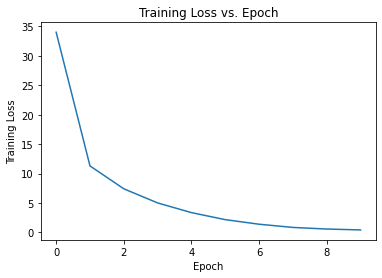

In [7]:
import matplotlib.pyplot as plt

# train_loss_history that contains the error values at each epoch during training
num_epochs = len(train_loss_history)

# Plot the learning curve
plt.plot(range(num_epochs), train_loss_history)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()



---



**Question 3 Part 3**



---



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

train_losses = []
test_losses = []

# Define the training function
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    avg_loss = 0
    num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        num += 1
    avg_loss/=num
    print('Train Epoch: {:.0f}%) \tLoss: {:.6f}'.format(epoch, avg_loss))
    train_losses.append(avg_loss)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True,
                               transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = datasets.MNIST('../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Initialize the network, optimizer and loss function
model = SimpleNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the network
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1%) 	Loss: 0.236137
Train Epoch: 2%) 	Loss: 0.094428
Train Epoch: 3%) 	Loss: 0.069202
Train Epoch: 4%) 	Loss: 0.054102
Train Epoch: 5%) 	Loss: 0.042829
Train Epoch: 6%) 	Loss: 0.037250
Train Epoch: 7%) 	Loss: 0.030754
Train Epoch: 8%) 	Loss: 0.027012
Train Epoch: 9%) 	Loss: 0.028055
Train Epoch: 10%) 	Loss: 0.023039

Test set: Average loss: 0.0016, Accuracy: 9777/10000 (98%)



In [11]:
# Define the test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    c = 0
    with torch.no_grad():
        for data, target in test_loader:
            c+=1
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).item()
            if c%64==1:
              print(loss)
            test_loss += loss # sum up batch loss
            test_losses.append(loss)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

test(model, device, test_loader, criterion)

0.08968494832515717
0.0008632459212094545
0.0011170991929247975

Test set: Average loss: 0.0016, Accuracy: 9777/10000 (98%)



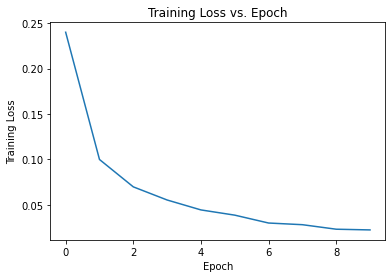

In [29]:
num_epochs = len(train_losses)

plt.plot(range(num_epochs), train_losses)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()



---


**Question 3 Part 4 Subpart 1**


---



In [22]:
import torch
import torchvision
import numpy as np

# Define the sigmoid and softmax activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Define the cross-entropy loss function
def cross_entropy_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # Convert PIL image to tensor
    torchvision.transforms.Normalize((0.1307,), (0.3081,)) # Normalize the image
])

# Load the MNIST dataset
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Set the dimensions of the layers
d = 784
d1 = 300
d2 = 200
d3 = 100
k = 10

# Initialize the weights randomly
W1 = np.zeros((d1, d), dtype=float)
W2 = np.zeros((d2, d1), dtype=float)
W3 = np.zeros((k, d2), dtype=float)

# Set the learning rate and number of epochs
lr = 1
n_epochs = 10

train_loss_history = []

# Train the network
for epoch in range(n_epochs):
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.reshape(-1, d)
        y = torch.nn.functional.one_hot(y, num_classes=k).numpy()
        
        # Forward pass
        z1 = np.dot(X, W1.T)
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2.T)
        a2 = sigmoid(z2)
        z3 = np.dot(a2, W3.T)
        y_hat = softmax(z3.T)
        
        # Compute the loss
        loss = cross_entropy_loss(y.T, y_hat)
        train_loss += loss
        
        # Backward pass
        delta3 = y_hat - y.T
        delta2 = np.dot(delta3.T, W3) * a2 * (1 - a2)
        delta1 = np.dot(delta2, W2) * a1 * (1 - a1)
        dW3 = np.dot(delta3, a2) / X.shape[0]
        dW2 = np.dot(delta2.T, a1) / X.shape[0]
        dW1 = np.dot(delta1.T, X) / X.shape[0]
        
        # Update the weights
        W1 -= lr * dW1
        W2 -= lr * dW2
        W3 -= lr * dW3
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    print(f'Epoch {epoch+1}, train_loss: {train_loss}')

Epoch 1, train_loss: 130.449597320112
Epoch 2, train_loss: 126.62541527968746
Epoch 3, train_loss: 126.21280629798996
Epoch 4, train_loss: 125.98610513073069
Epoch 5, train_loss: 125.86926760419072
Epoch 6, train_loss: 125.71752035331231
Epoch 7, train_loss: 125.65248765738622
Epoch 8, train_loss: 125.52362692174565
Epoch 9, train_loss: 125.44801719952258
Epoch 10, train_loss: 125.35572437573396


In [15]:
test_loss = 0

test_errors = []

prev_loss = 0

for i, (X, y) in enumerate(test_loader):
  X = X.reshape(-1, d)
  y = torch.nn.functional.one_hot(y, num_classes=k).numpy()
        
  # Forward pass
  z1 = np.dot(X, W1.T)
  a1 = sigmoid(z1)
  z2 = np.dot(a1, W2.T)
  a2 = sigmoid(z2)
  z3 = np.dot(a2, W3.T)
  y_hat = softmax(z3.T)
        
  # Compute the loss
  loss = cross_entropy_loss(y.T, y_hat)
  test_loss += loss
  if i%64==0:
    loss_new_batch = loss-prev_loss
    print(loss_new_batch)
    prev_loss = loss_new_batch
        
test_loss /= len(test_loader)
test_loss

118.40102947474156
7.818530212841779
122.01627001849431


123.8603459110885

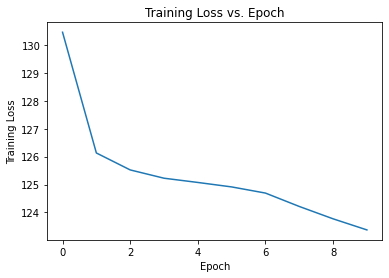

In [16]:
import matplotlib.pyplot as plt

# train_loss_history that contains the error values at each epoch during training
num_epochs = len(train_loss_history)

# Plot the learning curve
plt.plot(range(num_epochs), train_loss_history)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()



---



**Question 2 Part 1**


---



In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [50]:
import os

# Define the training data directory
train_dir = "/content/drive/MyDrive/languageID/"

# Define the character set
charset = "abcdefghijklmnopqrstuvwxyz "

# Define the smoothing parameter alpha
alpha = 0.5

# Initialize the counts for each language
e_count = 0
j_count = 0
s_count = 0

# Loop through the training files and count the number of documents in each class
for filename in os.listdir(train_dir):
    # Get the language label from the filename
    lang = filename[0]
    
    # Increment the count for the appropriate class
    if lang == "e":
        e_count += 1
    elif lang == "j":
        j_count += 1
    elif lang == "s":
        s_count += 1

# Calculate the prior probabilities with additive smoothing
e_prior = (e_count + alpha) / (e_count + j_count + s_count + alpha * 3)
j_prior = (j_count + alpha) / (e_count + j_count + s_count + alpha * 3)
s_prior = (s_count + alpha) / (e_count + j_count + s_count + alpha * 3)

# Print the prior probabilities
print("Prior probabilities:")
print("English: {:.3f}".format(e_prior))
print("Japanese: {:.3f}".format(j_prior))
print("Spanish: {:.3f}".format(s_prior))

Prior probabilities:
English: 0.333
Japanese: 0.333
Spanish: 0.333




---



**Question 2 Part 2 & 3**


---



In [59]:
import string

# initialize the count for each character to 0
char_counts = {char: 0 for char in charset}

for filename in os.listdir(train_dir):
    # Get the language label from the filename
    lang = filename[0]
    
    # Increment the count for the appropriate class
    if lang == "e":
      filepath = "/content/drive/MyDrive/languageID/" + filename
      with open(filepath) as file:
        for line in file:
          for char in line:
            if char in charset:
                char_counts[char] += 1

# calculate the total number of characters in the English training data
n_e = sum(char_counts.values())

# calculate the vector of class conditional probabilities for English
theta_e = [(char_counts[char] + alpha) / (n_e + 27*alpha) for char in charset]

print(theta_e)

[0.06163156484080746, 0.011948257134393207, 0.021794636685522437, 0.022133194148598514, 0.1059543793818505, 0.019988996882450028, 0.016010946691306125, 0.04656575773392205, 0.05471934996967089, 0.0008605002186516949, 0.003992156752105404, 0.030145720774732328, 0.02216140727052152, 0.05742780967427951, 0.06507356571541424, 0.016405930398228217, 0.0006912214871136566, 0.05054380792506595, 0.06377576210695594, 0.08329924247767637, 0.02565983438897431, 0.00918337118593858, 0.015474897374769005, 0.0011990576817277716, 0.013387126352466533, 0.0005219427555756182, 0.17944956199128215]


In [148]:
# initialize the count for each character to 0
char_counts = {char: 0 for char in charset}

for filename in os.listdir(train_dir):
    # Get the language label from the filename
    lang = filename[0]
    
    # Increment the count for the appropriate class
    if lang == "j":
      filepath = "/content/drive/MyDrive/languageID/" + filename
      with open(filepath) as file:
        for line in file:
          for char in line:
            if char in charset:
                char_counts[char] += 1

# calculate the total number of characters in the Japanese training data
n_j = sum(char_counts.values())

# calculate the vector of class conditional probabilities for Japanese
theta_j = [(char_counts[char] + alpha) / (n_j + 27*alpha) for char in charset]

Character        Theta_j
-----------  -----------
a            0.132126
b            0.00992638
c            0.00521438
d            0.0163707
e            0.0599913
f            0.00348203
g            0.0148809
h            0.0314768
i            0.0989693
j            0.00209615
k            0.0571849
l            0.00119532
m            0.0408315
n            0.0569424
o            0.0903768
p            0.000710264
q            5.19706e-05
r            0.0425985
s            0.0425985
t            0.0579818
u            0.0702815
v            0.000190559
w            0.0202858
x            1.73235e-05
y            0.0138415
z            0.00774361
             0.122633


In [61]:
# initialize the count for each character to 0
char_counts = {char: 0 for char in charset}

for filename in os.listdir(train_dir):
    # Get the language label from the filename
    lang = filename[0]
    
    # Increment the count for the appropriate class
    if lang == "s":
      filepath = "/content/drive/MyDrive/languageID/" + filename
      with open(filepath) as file:
        for line in file:
          for char in line:
            if char in charset:
                char_counts[char] += 1

# calculate the total number of characters in the Spanish training data
n_s = sum(char_counts.values())

# calculate the vector of class conditional probabilities for Spanish
theta_s = [(char_counts[char] + alpha) / (n_s + 27*alpha) for char in charset]

print(theta_s)

[0.10653656355302873, 0.009598032483191465, 0.03674720922433205, 0.040484213552230225, 0.11234968139642589, 0.007362217928038712, 0.007202516888384944, 0.0047750610856476675, 0.05000239551559481, 0.006723413769423639, 0.00023955155948065222, 0.05313253589280866, 0.02470575083443793, 0.0543462637941773, 0.07076353067058466, 0.02416276729961512, 0.007745500423207755, 0.058530431033106026, 0.06635578197614067, 0.03534184007537889, 0.034990497788140604, 0.005924908571154798, 0.00027149176741140586, 0.002571186738425667, 0.007394158135969465, 0.0033058115208330005, 0.16843668652282925]


In [151]:
from tabulate import tabulate

# Create a list of tuples, where each tuple contains the character and its corresponding theta_j value
rows = [(char, thetae, thetaj, thetas) for char, thetae, thetaj, thetas in zip(charset, theta_e, theta_j, theta_s)]

# Print the table using tabulate
print(tabulate(rows, headers=["Character", "English", "Japanese", "Spanish"]))

Character        English     Japanese      Spanish
-----------  -----------  -----------  -----------
a            0.0616316    0.132126     0.106537
b            0.0119483    0.00992638   0.00959803
c            0.0217946    0.00521438   0.0367472
d            0.0221332    0.0163707    0.0404842
e            0.105954     0.0599913    0.11235
f            0.019989     0.00348203   0.00736222
g            0.0160109    0.0148809    0.00720252
h            0.0465658    0.0314768    0.00477506
i            0.0547193    0.0989693    0.0500024
j            0.0008605    0.00209615   0.00672341
k            0.00399216   0.0571849    0.000239552
l            0.0301457    0.00119532   0.0531325
m            0.0221614    0.0408315    0.0247058
n            0.0574278    0.0569424    0.0543463
o            0.0650736    0.0903768    0.0707635
p            0.0164059    0.000710264  0.0241628
q            0.000691221  5.19706e-05  0.0077455
r            0.0505438    0.0425985    0.0585304
s           



---



**Question 2 Part 4**


---



In [45]:
# Define the vocabulary (26 letters and a space)
vocabulary = list(string.ascii_lowercase) + [' ']

# Initialize the bag-of-words vector with all zeros
bow_vector = [0] * len(vocabulary)

# Read the contents of the file e10.txt
with open('/content/drive/MyDrive/languageID/e10.txt', 'r', encoding='utf-8') as file:
    contents = file.read()

# Count the occurrences of each word in the document
for word in contents:
    if word in vocabulary:
        index = vocabulary.index(word)
        bow_vector[index] += 1

# Print the bag-of-words vector
print(bow_vector)

[164, 32, 53, 57, 311, 55, 51, 140, 140, 3, 6, 85, 64, 139, 182, 53, 3, 141, 186, 225, 65, 31, 47, 4, 38, 2, 498]




---



**Question 2 Part 5 & 6**


---



In [137]:
import os
import numpy as np

# Define the vocabulary
vocab = "abcdefghijklmnopqrstuvwxyz "

# Define the class labels
labels = ["e", "j", "s"]

# Define the smoothing parameter
alpha = 0.5

# Initialize the count matrices for each class
count_matrices = {label: np.zeros(len(vocab)) for label in labels}

# Count the occurrences of each character in each document
for filename in os.listdir("/content/drive/MyDrive/languageID"):
    label = filename[0]
    with open(os.path.join("/content/drive/MyDrive/languageID/", filename)) as f:
        text = f.read().lower()
        for char in text:
            if char in vocab:
                count_matrices[label][vocab.index(char)] += 1

# Calculate the total number of characters in each class
class_totals = {label: np.sum(count_matrices[label]) for label in labels}

print(class_totals)

# Calculate the prior probabilities of each class
prior_probs = {label: (np.sum([filename.startswith(label) for filename in os.listdir("/content/drive/MyDrive/languageID/")]) + alpha) / (len(os.listdir("/content/drive/MyDrive/languageID/")) + alpha * len(labels)) for label in labels}

print(prior_probs)

# Calculate the conditional probabilities of each character given each class
cond_probs = {label: np.log((count_matrices[label] + alpha) / (class_totals[label] + alpha * len(vocab))) for label in labels}

print(cond_probs)

# Load the document to be classified
with open("/content/drive/MyDrive/languageID/e10.txt") as f:
    text = f.read().lower()

# Calculate the likelihood of the document given each class
likelihoods = {label: np.sum([cond_probs[label][vocab.index(char)] for char in text if char in vocab]) for label in labels}

print(likelihoods)

# Calculate the posterior probabilities of each class given the document
posterior_probs = {label: np.log(prior_probs[label]) + likelihoods[label] for label in labels}

print(posterior_probs)

{'e': 35431.0, 'j': 28849.0, 's': 31295.0}
{'e': 0.3333333333333333, 'j': 0.3333333333333333, 's': 0.3333333333333333}
{'e': array([-2.78658112, -4.42716986, -3.82609136, -3.8106768 , -2.24474666,
       -3.91257331, -4.13448262, -3.06688982, -2.90553788, -7.05799669,
       -5.52342365, -3.5017123 , -3.80940291, -2.8572266 , -2.73223687,
       -4.1101124 , -7.27705025, -2.98491484, -2.75238207, -2.48531582,
       -3.66282837, -4.69036091, -4.16853609, -6.7262193 , -4.31346175,
       -7.55795264, -1.7178611 ]), 'j': array([ -2.02399577,  -4.61255992,  -5.25633537,  -4.11226071,
        -2.81355509,  -5.66014073,  -4.20767671,  -3.45850357,
        -2.31294608,  -6.16765509,  -2.8614649 ,  -6.72933913,
        -3.19830073,  -2.86571506,  -2.40376783,  -7.24987357,
        -9.86483335,  -3.15593559,  -3.15593559,  -2.84762593,
        -2.65524657,  -8.56555036,  -3.89783227, -10.96344563,
        -4.28008469,  -4.86088704,  -2.0985577 ]), 's': array([-2.23926703, -4.64619715, -3.30369

In [73]:
# Print the posterior probabilities
print("p̂(x|y=e) =", np.exp(posterior_probs["e"]))
print("p̂(x|y=j) =", np.exp(posterior_probs["j"]))
print("p̂(x|y=s) =", np.exp(posterior_probs["s"]))

p̂(x|y=e) = 0.0
p̂(x|y=j) = 0.0
p̂(x|y=s) = 0.0




---



**Question 2 Part 7**


---


In [136]:
import os

# Load test set files and extract true class labels and bag-of-characters representations
test_files = ['10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt']
true_labels = []
predicted_labels = []
test_docs = []
for file in test_files:
  for i in ['s', 'j', 'e']:
    # Load the document to be classified
    true_label = i
    true_labels.append(true_label)
    filename = "/content/drive/MyDrive/languageID/" + i + file
    with open(filename) as f:
      text = f.read().lower()

    likelihood = {label: np.sum([cond_probs[label][vocab.index(char)] for char in text if char in vocab]) for label in labels}
    predicted_label = max(likelihood, key=likelihood.get)
    likelihood.clear()
    predicted_labels.append(predicted_label)

# Generate confusion matrix
confusion_matrix = np.zeros((len(labels), len(labels)))
for i in range(30):
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]
    true_idx = labels.index(true_label)
    pred_idx = labels.index(predicted_label)
    confusion_matrix[true_idx][pred_idx] += 1

# Print confusion matrix
print('Confusion matrix:')
print('\t\tPredicted labels')
print('\t\t' + '\t'.join(labels))
for i in range(len(labels)):
    print(f'True label {labels[i]}:\t' + '\t'.join([str(int(x)) for x in confusion_matrix[i]]))
    
# Compute overall accuracy
accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
print(f'\nOverall accuracy: {accuracy:.2f}')

Confusion matrix:
		Predicted labels
		e	j	s
True label e:	10	0	0
True label j:	0	10	0
True label s:	0	0	10

Overall accuracy: 1.00
